# Estimating the effective reproduction number
In epidemiology, a virus reproduction number represents the number of cases, on average, that a single infected case generates.   Here we will consider the effective reproduction number $R_e$, which considers both the infectiousness of the virus as well as the impact of protective measures (social distancing, mask wearing,  etc...) limiting the spread. 

A simple, but often effective, model of COVID-19 dynamics is given by 

$$
I_{t+T} = R_e(t) I_t,
$$

where $I_t$ represents the number of new cases reported on day $t$ and $T$ is an integer representing the time between when someone contracts the virus (exposure) and when they show symptoms and get tested.    Note that similar expressions are used in finance for modeling stock returns. 

Taking the log of both sides results in 

$$
\log(I_{t+T})-\log(I_{t}) = \log(R_e(t)).
$$

Our goal is to estimate $R(t)$ for each day $t$ using noisy observations of $\log(I_{t+T})-\log(I_{t})$.   Formally, let $X_t = \log(R_e(t))$.  We assume 

$$
d_t = X_t + \epsilon_t,
$$

and

$$
X_{t+1} = X_t + Y_t
$$

where $X_t$ is the log reproduction number, $d_t  = \log(I_{obs,t+T})-\log(I_{obs,t})$ is an observation of the effective reproduction number, $\epsilon_t$ is an additive Gaussian random variable representing the mismatch between our modeled $X_t$ and reality, and $Y_t$ is a random variable representing th possible change in the log reproduction number over one day.  Note the subscript $obs$ used to denote that $I_{obs,t}$ is the *observed number* of new cases on $t$ whereas $I_{t}$ is the *modeled* number of new cases on day $t$.

### Conditioning
Our goal is to characterize the log reproduction rate $X_t$ given observations at all  previous times, i.e., $d_1,d_2,\ldots, d_t$. Using Bayes' rule, we have

$$
f(x_t | d_1, d_2, \ldots,  d_t) \propto f(d_t | x_t, d_1, d_2, \ldots,  d_{t-1}) f(x_t | d_1, d_2, \ldots,  d_{t-1})
$$

Using the noise model above, which relates $X_t$ to $d_t$, we see that $d_t$ and $d_{t-1}$ are independent *given* $X_t$.  Thus, we can simplify Bayes' rule to 

$$
f(x_t | d_1, d_2, \ldots,  d_t) \propto f(d_t | x_t) f(x_t | d_1, d_2, \ldots,  d_{t-1})
$$

In this exercise, all of the densities are Gaussian and we can therefore use known expressions to obtain the posterior mean and variance.  Let $\mu_t$ and $\sigma_t^2$ denote the prior mean and variance used in $f(x_t | d_1, d_2, \ldots,  d_{t-1})$.  The posterior mean and variance are then given by

$$
\begin{eqnarray}
f(x_t | d_1, d_2, \ldots,  d_t) &=&  N(\mu_{post,t}, \sigma^2_{post,t})\\
& = & N\left( \frac{\sigma_t^2 d_t + \sigma_\epsilon^2\mu_t}{\sigma_t^2 + \sigma_\epsilon^2}, \frac{\sigma_\epsilon^2\sigma_t^2}{\sigma_t^2 + \sigma_\epsilon^2}\right)
\end{eqnarray}
$$


### Propagation
We now turn to the prior density $f(x_t | d_1, d_2, \ldots,  d_{t-1})$, which we want to define using the process model $X_{t+1} = X_t + Y_t$.  Formally, we have
$$
\begin{eqnarray}
f(x_t | d_1, d_2, \ldots, d_{t-1}) &=& \int f(x_t, x_{t-1} | d_1, d_2, \ldots, d_{t-1}) dx_{t-1}\\
&=& \int f(x_t| x_{t-1}, d_1, d_2, \ldots, d_{t-1}) f(x_{t-1}|d_1, d_2, \ldots, d_{t-1} ) dx_{t-1}\\ 
&=& \int f(x_t| x_{t-1}) f(x_{t-1}|d_1, d_2, \ldots, d_{t-1} ) dx_{t-1}
\end{eqnarray} 
$$
where we have used the conditional independence of $X_t$ and $d_{t-1}$ given $X_{t-1}$.  This is called the Chapman-Kolmogorov equation.  In our problem, all of the densities are Gaussian and the mean and variance of the marginal density $f(x_t | d_1, d_2, \ldots, d_{t-1})$ can be neatly written in terms of the mean and variance of $X_{t-1}$ and $Y_{t-1}$:

$$
f(x_t | d_1, d_2, \ldots, d_{t-1}) = N(\mu_{post,t-1},\, \sigma_{post,t-1}^2 + \sigma_{y}^2)
$$

In essence, this step is "propagating" the information from day $t-1$ to day $t$.

### Putting it all together
The code below combines the propagation and conditioning steps above to recursively compute the posterior $f(x_t | d_1, d_2, \ldots,  d_t)$ for all days $t$.  The posterior mean and covariance from day $t-1$ are used with the process model to define the prior on day $t$.  That is then updated with the observation on day $t$.


In [1]:
from process_covidtracking import GetData, ExtractDataFrame
import datetime
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd
pd.plotting.register_matplotlib_converters()

#### Set some model parameters

In [2]:
T = 8 # The delay time between exposure and reported test
dynamics_var = 0.2**2 # the variance of Y_t
obs_var = 2.0**2 # The variance of epsilon_t
state = 'AZ' # The state of interest

#### Read the data using tools from process_covidtracking.py

In [3]:
start_date = datetime.date(2020,3,15)
df, locs = ExtractDataFrame(GetData('./', start_date), start_date)

df.head()

,,cum_positive,cum_total,curr_hosp,cum_hosp,curr_icu,cum_icu,curr_vent,cum_vent,cum_death,new_death,new_cases
state,date,,,,,,,,,,,
AK,2020-03-15,1.0,144,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0
AL,2020-03-15,12.0,86,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0
AR,2020-03-15,16.0,149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
AZ,2020-03-15,12.0,183,NaN,36.0,NaN,NaN,NaN,NaN,0.0,0,0.0
CA,2020-03-15,293.0,1209,NaN,NaN,NaN,NaN,NaN,NaN,5.0,0,0.0


In [4]:
def FormatPlot():
    ymin, ymax = plt.ylim()
    label_days = []
    for month in range(2,9):
        plt.plot([datetime.date(2020,month,1),datetime.date(2020,month,1)],[ymin,ymax],'--k')
        for day in [1,15]:
            label_days.append(datetime.date(2020,month,day))
    plt.xticks(label_days, rotation=25,fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(datetime.date(2020,3,1), datetime.date(2020,8,1))
    plt.ylim(0,ymax)

    

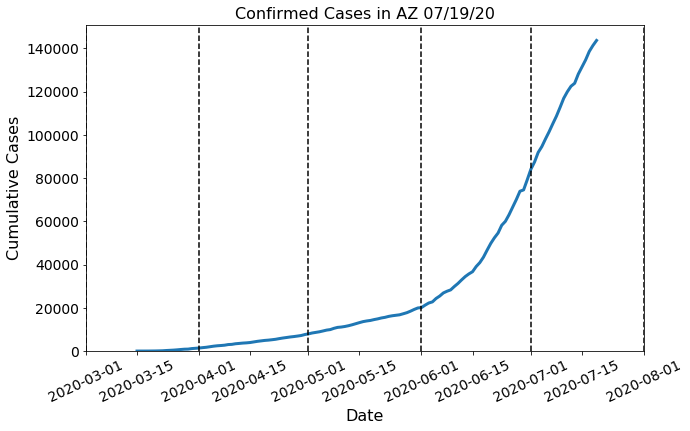

In [5]:

plt.figure(figsize=(10,6))
plt.plot(df.loc[state]['cum_positive'], linewidth=3)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Cumulative Cases', fontsize=16)
plt.title('Confirmed Cases in ' + state + ' ' + df.loc[state].index[-1].strftime("%m/%d/%y"), fontsize=16)

FormatPlot()
plt.savefig('CumulativeCases_'+state +'.png')
plt.show()

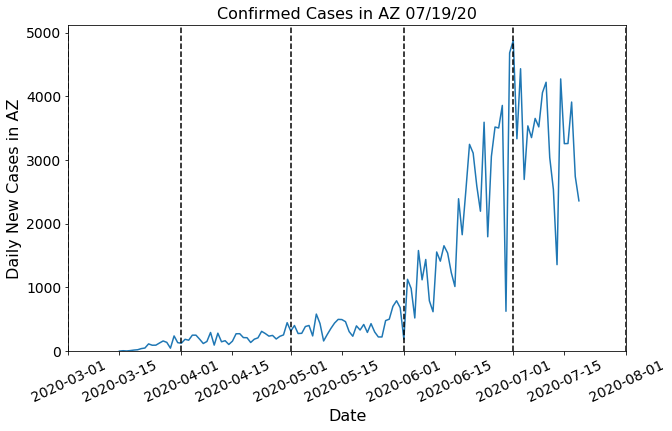

In [6]:
plt.figure(figsize=(10,6))
plt.plot(df.loc[state]['new_cases'])
plt.xlabel('Date', fontsize=16)
plt.ylabel('Daily New Cases in ' + state, fontsize=16)
plt.title('Confirmed Cases in ' + state + ' ' + df.loc[state].index[-1].strftime("%m/%d/%y"), fontsize=16)


FormatPlot()
plt.savefig('NewCases_'+state +'.png')
plt.show()

In [7]:
upper_R0 = 6.0
lower_R0 = 0.5

prior_mean =  0.5*(np.log(upper_R0) + np.log(lower_R0))
prior_var = 0.25*(np.log(upper_R0) - np.log(lower_R0))


In [8]:
def LognormalPDF(r0, mean, var):

    log_r0 = np.log(r0)
    return np.exp(-(0.5/var)*(log_r0-mean)**2)/(r0*np.sqrt(2.0*np.pi*var))


In [9]:
r0s = np.linspace(0.1,6.0,100)
prior_pdf = LognormalPDF(r0s, prior_mean, prior_var)

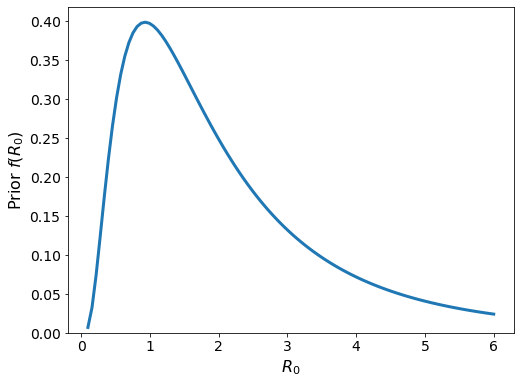

In [10]:
plt.figure(figsize=(8,6))

plt.plot(r0s,prior_pdf, linewidth=3)

ymin, ymax = plt.ylim()
plt.ylim(0,ymax)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$R_0$', fontsize=16)
plt.ylabel('Prior $f(R_0)$', fontsize=16)
plt.savefig('PriorPDF.png')
plt.show()

In [11]:
def ComputePost(prior_mean, prior_var, obs_val, obs_var):
    """ Computes the posterior mean and variance 
        given an observation with value obs_val 
        and variance obs_var. 
    """
    post_var = obs_var*prior_var / (prior_var + obs_var)
    post_mean = post_var *(obs_val/obs_var + prior_mean/prior_var)
    
    return post_mean, post_var

def EvolveDist(prior_mean, prior_var, dynamics_var):
    return prior_mean, prior_var + dynamics_var

In [12]:
curr_mean = np.copy(prior_mean)
curr_var = np.copy(prior_var)

num_days = df.loc[state].shape[0]-T

obs_vals = np.zeros(num_days) # holds the difference in log of the new values
log_r0_mean = np.zeros(num_days)
log_r0_var = np.zeros(num_days)

for day_ind in range(num_days):
    if((df.loc[state]['new_cases'].iloc[day_ind+T]>0)&(df.loc[state]['new_cases'].iloc[day_ind]>0)):

        obs_vals[day_ind] = (np.log(df.loc[state]['new_cases'].iloc[day_ind+T])-np.log(df.loc[state]['new_cases'].iloc[day_ind]))

        post_mean, post_var = ComputePost(curr_mean, curr_var, obs_vals[day_ind], obs_var)

        log_r0_mean[day_ind] = post_mean
        log_r0_var[day_ind] = post_var
    
        curr_mean, curr_var = EvolveDist(post_mean, post_var, dynamics_var)
    else:
        log_r0_mean[day_ind] = curr_mean
        log_r0_var[day_ind] = curr_var
        curr_mean, curr_var = EvolveDist(curr_mean, curr_var, dynamics_var)
        

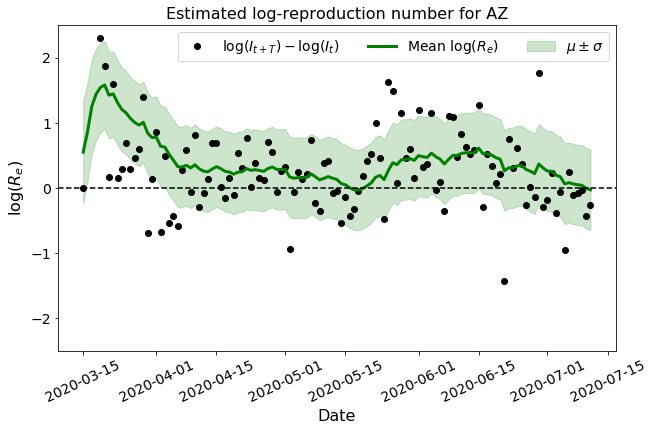

In [13]:
dates = df.loc[state]['new_cases'].iloc[0:-T].index


plt.figure(figsize=(10,6))

plt.plot(dates,obs_vals,'ok',label='$\log(I_{t+T}) - \log(I_{t})$')

plt.fill_between(dates,log_r0_mean-np.sqrt(log_r0_var), log_r0_mean+np.sqrt(log_r0_var), color='g', alpha=0.2, label='$\mu\pm\sigma$')

plt.plot(dates,log_r0_mean, '-g', linewidth=3, label='Mean $\log(R_e)$')

plt.legend(fontsize=14, ncol=3)
xmin, xmax = plt.xlim()
plt.plot([xmin,xmax],[0,0],'--k')

ymin, ymax = plt.ylim()
label_days = []
for month in range(2,9):
    for day in [1,15]:
        label_days.append(datetime.date(2020,month,day))

plt.xticks(label_days, rotation=25,fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(xmin,xmax)

plt.title('Estimated log-reproduction number for ' + state, fontsize=16)
plt.ylabel('$\log(R_e)$', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylim(-2.5,2.5)

plt.savefig('Posterior_LogScale_' + state +'.png')
plt.show()

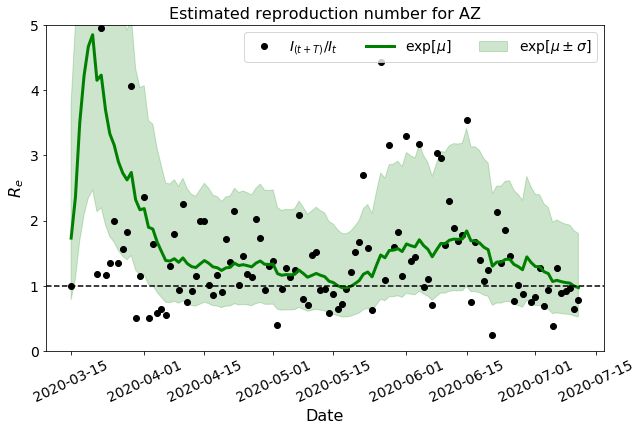

In [14]:

dates = df.loc[state]['new_cases'].iloc[0:-T].index


plt.figure(figsize=(10,6))

plt.plot(dates,np.exp(obs_vals),'ok',label='$I_{(t+T)}/I_{t}$')

plt.fill_between(dates,np.exp(log_r0_mean-np.sqrt(log_r0_var)), np.exp(log_r0_mean+np.sqrt(log_r0_var)), color='g', alpha=0.2, label='$\exp[\mu\pm\sigma]$')

plt.plot(dates,np.exp(log_r0_mean), '-g', linewidth=3, label='$\exp[\mu]$')

plt.legend(fontsize=14, ncol=3)
xmin, xmax = plt.xlim()
plt.plot([xmin,xmax],[1,1],'--k')

ymin, ymax = plt.ylim()
label_days = []
for month in range(2,9):
    for day in [1,15]:
        label_days.append(datetime.date(2020,month,day))

plt.xticks(label_days, rotation=25,fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(xmin,xmax)

plt.title('Estimated reproduction number for ' + state, fontsize=16)
plt.ylabel('$R_e$', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylim([0,5])

plt.savefig('Posterior_' + state +'.png')
plt.show()